In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [135]:
dust_prior = gpdp.DustPrior()
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

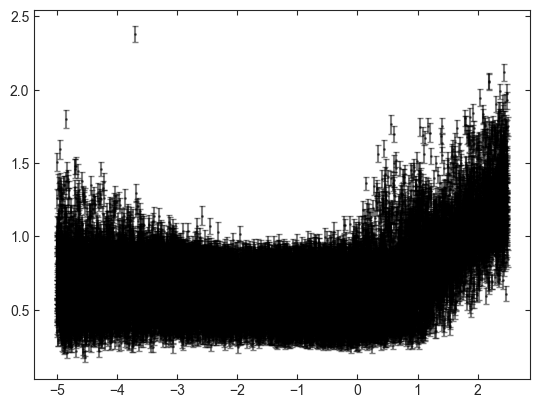

In [136]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -10, -5, 5)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

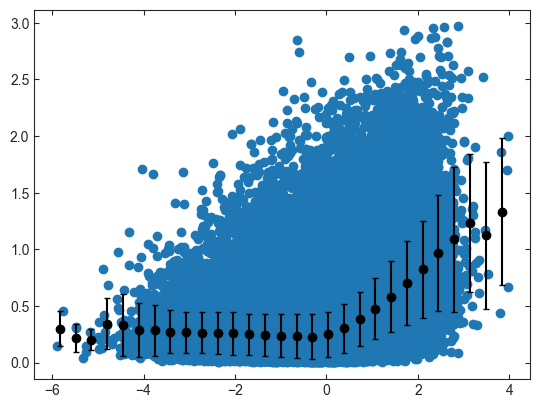

In [137]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -6, 4, 30)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [138]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

17.530815625793295
12.518153919859042
8.25808937904399
4.897156777774211
2.5594430720500214
1.3069986373282398
1.0372530709061545
0.9943768755029678
0.95171841641818
0.909198233896264
0.8667747775857878
0.8244328536817626
0.782175979537784
0.7400208284454842
0.6979927808625221
0.6561220414469584
0.6144400726792398
0.5729763409304516
0.5317555936085276
0.49079603139944544
0.45010869214814575
0.4096980439976561
0.369563305249775
0.32969969210573347
0.2900989374342326
0.2507489833778459
0.21163337228840823
0.172731192059529
0.13401835297174106
0.09547056742857828
0.05706783983323189
0.018799736704561365
-0.019329631349561296
-0.05729801036909994
-0.09506358855481727
-0.13256606624651904
-0.16972996993689432
-0.20646954835890224
-0.24269437066791139
-0.2783147377502103
-0.3132461703548155
-0.34741248549711395
-0.3807472525636357
-0.4131936831679863
-0.4447032194850053
-0.47523322438464244
-0.504744236843994
-0.5331972441242332
-0.560551354363453
-0.58676215152415
-0.6117809014761001
-0.635

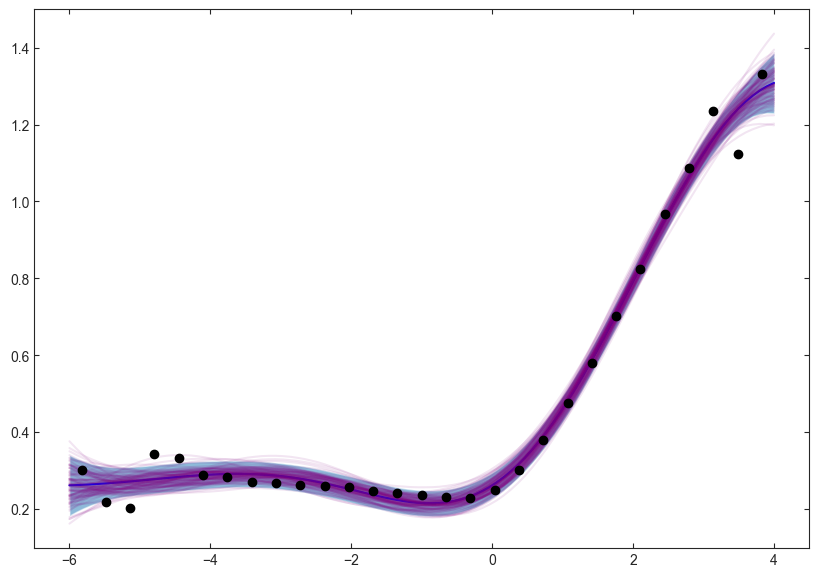

In [142]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-6, 4, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [1.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

17.51332144743939
12.499863519068564
8.23889581843689
4.876936903994719
2.5380509531487943
1.2842519678532702
1.0129283395841409
0.968263230423265
0.9235762919802354
0.8787737649520673
0.8337968673102585
0.788611397826071
0.743201191861806
0.6975637915921159
0.6517074585314971
0.6056490355157147
0.5594123650220262
0.5130270810002759
0.4665276544433738
0.4199526098158002
0.3733438513099582
0.3267460509637273
0.28020605877095156
0.23377230071795913
0.1874941364090384
0.14142115577880401
0.09560240657521714
0.05008556289290353
0.004916071090542546
-0.03986365857836654
-0.084214914534934
-0.12810308148047714
-0.1714976650305608
-0.2143718928398936
-0.2567019477079184
-0.2984660188065821
-0.3396434617716193
-0.3802143794091538
-0.4201598409229246
-0.4594627670669532
-0.4981092831348086
-0.5360901556872215
-0.5734018379059349
-0.6100466747045626
-0.6460319544138878
-0.6813677104174566
-0.7160634312157741
-0.7501240797024499
-0.7835459986904808
-0.8163133467880719
-0.8483956473974262
-0.87974

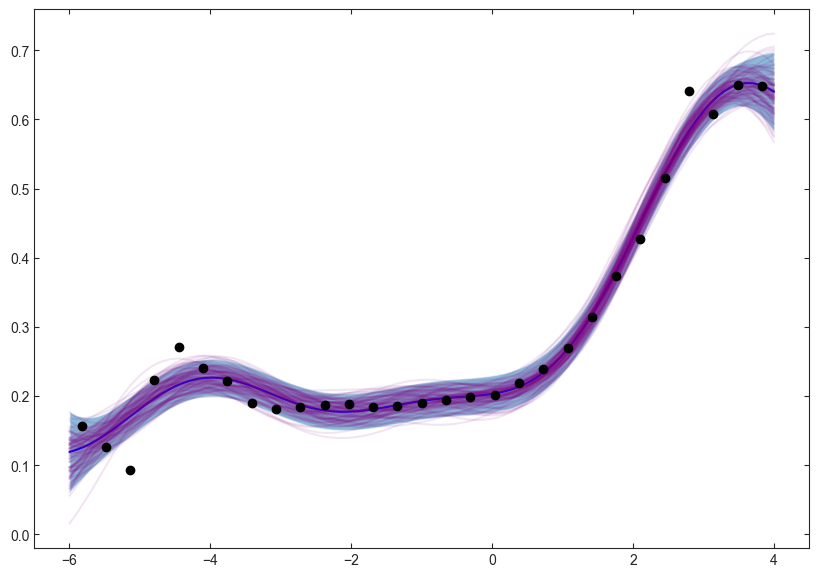

In [143]:
test_sfrs = torch.linspace(-6, 4, 100)
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_sfrs, train_dust2_errs, [1.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds, test_sfrs, train_sfrs, train_dust2_errs, train_dust2_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds.sample().numpy(), c='purple', alpha=0.1)

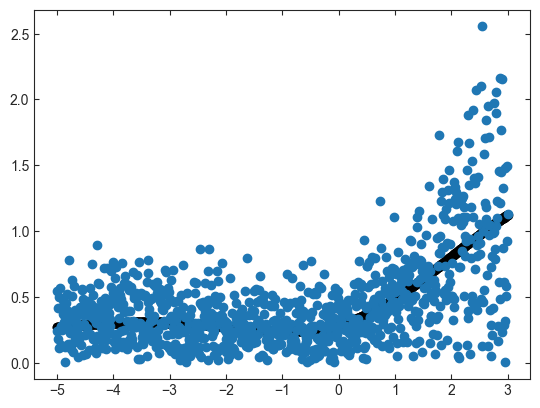

In [144]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()
sig_dust2 = f_preds_sig.sample().numpy()
sig_dust2 = np.where(sig_dust2<0.001, 0.001, sig_dust2)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, sig_dust2, 0.0, 4.0, len(test_sfrs)))

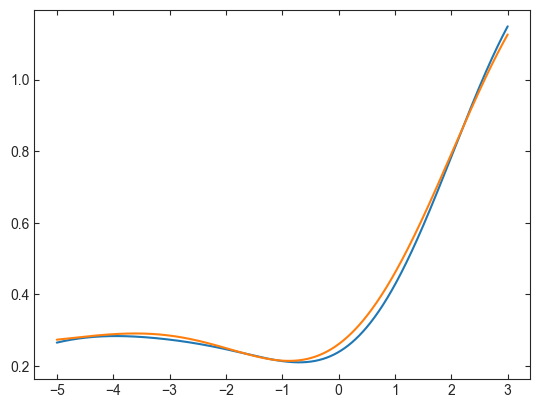

In [187]:
recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(9999999999)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, torch.from_numpy(dust_prior.dust2_grid))
mean_dust2_sample = f_preds_mu.sample().numpy()
mean_dust2 = f_preds_mu.mean.detach().numpy()
delta_dust2 = mean_dust2_sample - mean_dust2
plt.plot(dust_prior.dust2_grid, mean_dust2_sample)
plt.plot(dust_prior.dust2_grid, mean_dust2)

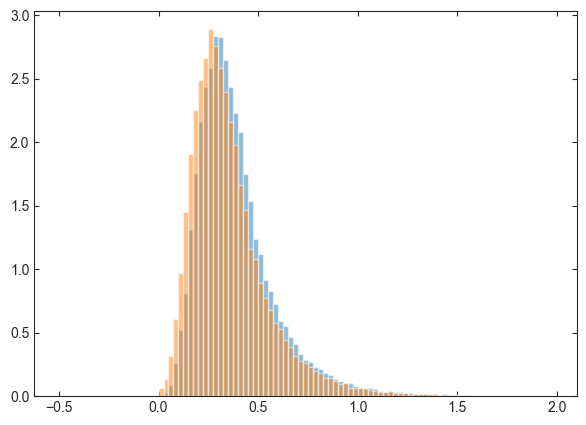

In [190]:

recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(9999999999)
delta = np.interp(recent_sfrs, dust_prior.dust2_grid, delta_dust2)
sfrs = np.random.uniform(-6, 4, 1000000)
sorted_inds = recent_sfrs.argsort()[:]
sorted_sfrs = recent_sfrs[sorted_inds]
sorted_dust2 = dust2[sorted_inds]
sorted_delta = delta[sorted_inds]

dust2 = np.interp(sfrs, sorted_sfrs, sorted_dust2)
delta = np.interp(sfrs, sorted_sfrs, sorted_delta)

sfr_point = 1
inds = np.where((sfrs<sfr_point)&(sfrs>sfr_point-0.5))[0]

f, ax = plt.subplots(1, 1, figsize=(7, 5))
bins = np.arange(-0.5, 2, 0.025)
histogram = ax.hist(dust2[inds], density=True, bins=bins, alpha=0.5)
dust2 = abs(dust2 + delta)
histogram = ax.hist(dust2[inds], density=True, bins=bins, alpha=0.5)

In [189]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust2sig.pth')

In [ ]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, -10, -5, 2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

In [ ]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [12]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

In [ ]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [ ]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust_index_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index_errs, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [ ]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust_index = f_preds.sample().numpy()
sig_dust_index = f_preds_sig.sample().numpy()
sig_dust_index = np.where(sig_dust_index<0.001, 0.001, sig_dust_index)
#scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, sig_dust_index, -2.2, 0.4, len(test_tau)))

In [16]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust_indexsig.pth')

In [ ]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, -10, -5, 2)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, -10, -5, 2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


In [ ]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

In [ ]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [ ]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [ ]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 2000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.001, 0.001, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [22]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')